# Facebook Prophet Demonstration - Peyton Manning Page Views

In this notebook, we will use Facebook Prophet to forecast the daily page views for the Wikipedia page of Peyton Manning.

**Who is Peyton Manning?**
Peyton Manning is a former American football quarterback who played in the National Football League (NFL) for 18 seasons. He is considered one of the greatest quarterbacks of all time.

**Why this dataset?**
The dataset contains log daily page views for the Peyton Manning Wikipedia page. It is a classic example used in Prophet documentation because it exhibits strong seasonality and clear holiday effects. Manning's popularity (and thus page views) spikes during the NFL season, playoffs, and especially the Super Bowls he played in. This makes it an excellent dataset to demonstrate how Prophet handles:
- **Trend changes**: Shifts in popularity over his career.
- **Seasonality**: Weekly (games on Sundays/Mondays) and yearly (NFL season) patterns.
- **Holiday effects**: Specific events like the Super Bowl and playoffs.

The dataset includes a `ds` column for the date and a `y` column for the log daily page views.

## 0-Setup
In this section, we will install the necessary libraries and import them. We are using `prophet` for forecasting and `pandas` for data manipulation.

In [54]:
#%pip install prophet

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

## 1-Data Loading and Exploration
We will load the Peyton Manning dataset which contains log daily page views. Prophet requires columns named `ds` (date) and `y` (value).

In [55]:
url = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'
df = pd.read_csv(url)

print("Dataset Head:")
display(df.head())

Dataset Head:


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


### Exploratory Data Analysis
Before modeling, let's explore the dataset to understand its characteristics: check for missing values, gaps in the time series, and basic statistics.

=== Dataset Overview ===
Date range: 2007-12-10 to 2016-01-20
Total observations: 2905
Missing values: 0
Missing dates (gaps): 59

=== Summary Statistics ===


count    2905.000000
mean        8.138958
std         0.845957
min         5.262690
25%         7.514800
50%         7.997999
75%         8.580168
max        12.846747
Name: y, dtype: float64

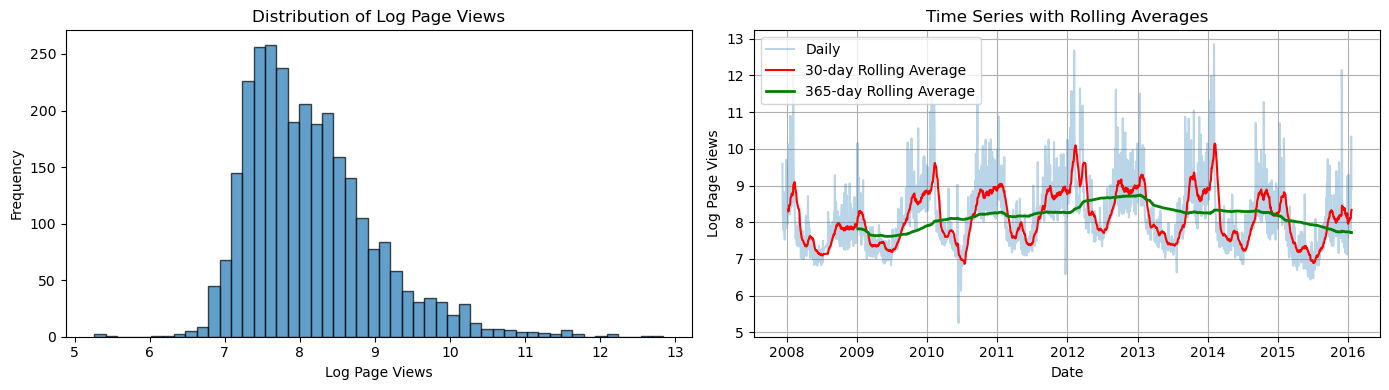

In [56]:
# Convert ds to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Basic statistics
print("=== Dataset Overview ===")
print(f"Date range: {df['ds'].min().date()} to {df['ds'].max().date()}")
print(f"Total observations: {len(df)}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Check for gaps in the time series
date_range = pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='D')
missing_dates = date_range.difference(df['ds'])
print(f"Missing dates (gaps): {len(missing_dates)}")

print("\n=== Summary Statistics ===")
display(df['y'].describe())

# Show the data distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram
axes[0].hist(df['y'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Log Page Views')
axes[0].set_xlabel('Log Page Views')
axes[0].set_ylabel('Frequency')

# Rolling average to show trend
df_plot = df.set_index('ds')
axes[1].plot(df_plot.index, df_plot['y'], alpha=0.3, label='Daily')
axes[1].plot(df_plot.index, df_plot['y'].rolling(window=30).mean(), color='red', label='30-day Rolling Average')
axes[1].plot(df_plot.index, df_plot['y'].rolling(window=365).mean(), color='green', linewidth=2, label='365-day Rolling Average')
axes[1].set_title('Time Series with Rolling Averages')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Log Page Views')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Reset index for later use
df = df.reset_index(drop=True) if 'ds' not in df.columns else df

### Zooming In: Weekly Seasonality and Holiday Effects
Let's zoom in on a specific period to visualize the weekly patterns and the impact of special events like the Super Bowl.

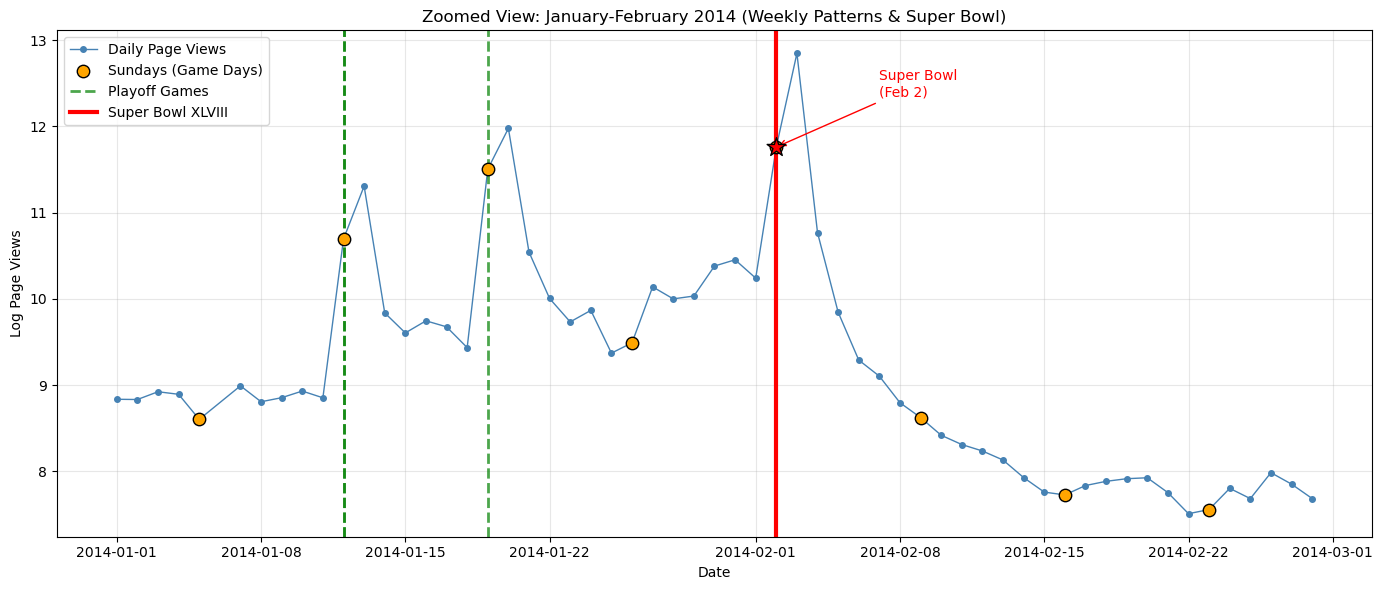


=== Weekly Pattern Analysis (Jan-Feb 2014) ===
day_of_week
Monday       10.047
Tuesday       9.252
Wednesday     9.029
Thursday      8.972
Friday        8.924
Saturday      8.857
Sunday        9.495
Name: y, dtype: float64


In [68]:
# Zoom in on January-February 2014 (includes Super Bowl XLVIII on Feb 2, 2014)
zoom_start = '2014-01-01'
zoom_end = '2014-02-28'
df_zoom = df[(df['ds'] >= zoom_start) & (df['ds'] <= zoom_end)].copy()

# Add day of week for coloring
df_zoom['day_of_week'] = df_zoom['ds'].dt.day_name()
df_zoom['is_weekend'] = df_zoom['ds'].dt.dayofweek >= 5  # Saturday=5, Sunday=6

# Key dates
super_bowl_2014 = pd.Timestamp('2014-02-02')
playoff_dates_in_range = ['2014-01-12', '2014-01-19']

fig, ax = plt.subplots(figsize=(14, 6))

# Plot daily values
ax.plot(df_zoom['ds'], df_zoom['y'], 'o-', color='steelblue', linewidth=1, markersize=4, label='Daily Page Views')

# Highlight weekends (Sundays - NFL game days)
sundays = df_zoom[df_zoom['ds'].dt.dayofweek == 6]
ax.scatter(sundays['ds'], sundays['y'], color='orange', s=80, zorder=5, label='Sundays (Game Days)', edgecolor='black')

# Mark playoff games
for playoff_date in playoff_dates_in_range:
    ax.axvline(x=pd.Timestamp(playoff_date), color='green', linestyle='--', alpha=0.7, linewidth=2)
ax.axvline(x=pd.Timestamp(playoff_dates_in_range[0]), color='green', linestyle='--', alpha=0.7, linewidth=2, label='Playoff Games')

# Mark Super Bowl
ax.axvline(x=super_bowl_2014, color='red', linestyle='-', linewidth=3, label='Super Bowl XLVIII')
ax.scatter([super_bowl_2014], df_zoom[df_zoom['ds'] == super_bowl_2014]['y'].values, 
           color='red', s=200, zorder=10, marker='*', edgecolor='black')

ax.set_title('Zoomed View: January-February 2014 (Weekly Patterns & Super Bowl)', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Log Page Views')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Add annotations
ax.annotate('Super Bowl\n(Feb 2)', xy=(super_bowl_2014, df_zoom[df_zoom['ds'] == super_bowl_2014]['y'].values[0]),
            xytext=(super_bowl_2014 + pd.Timedelta(days=5), df_zoom['y'].max() - 0.5),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Show weekly pattern summary
print("\n=== Weekly Pattern Analysis (Jan-Feb 2014) ===")
weekly_avg = df_zoom.groupby('day_of_week')['y'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print(weekly_avg.round(3))

### Train/Test Split
We will split the data into training and test sets. The last 2 years will be used as the test set to evaluate model performance.

Training set: 2007-12-10 to 2014-01-20 (2178 days)
Test set: 2014-01-21 to 2016-01-20 (727 days)


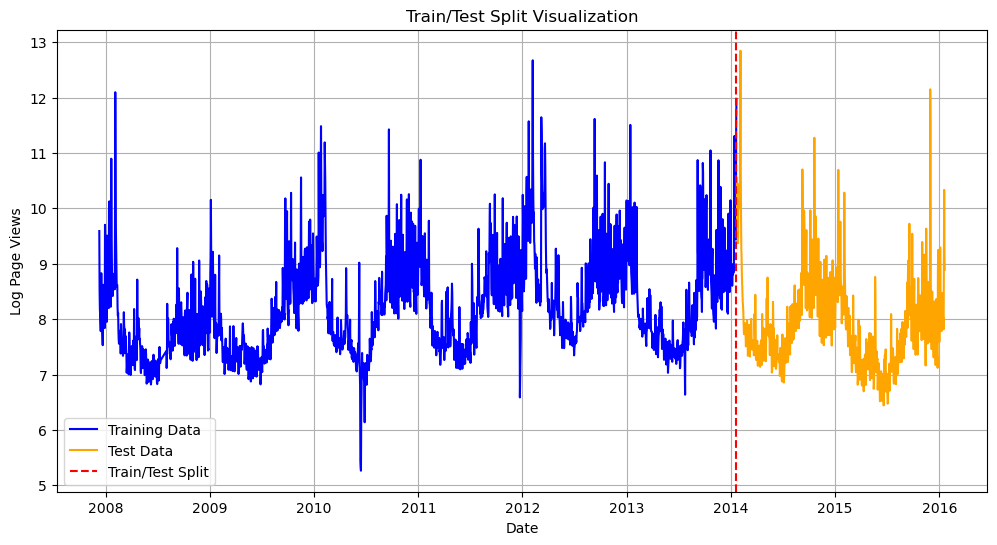

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split: last 2 years as test set
cutoff_date = df['ds'].max() - pd.DateOffset(years=2)
train = df[df['ds'] <= cutoff_date]
test = df[df['ds'] > cutoff_date]

print(f"Training set: {train['ds'].min().date()} to {train['ds'].max().date()} ({len(train)} days)")
print(f"Test set: {test['ds'].min().date()} to {test['ds'].max().date()} ({len(test)} days)")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.plot(test['ds'], test['y'], label='Test Data', color='orange')
plt.axvline(x=cutoff_date, color='red', linestyle='--', label='Train/Test Split')
plt.title('Train/Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Log Page Views')
plt.legend()
plt.grid(True)
plt.show()

## 2-Data Processing
We will define holidays to improve the model's accuracy. Specifically, we'll account for playoff dates and Super Bowls where Peyton Manning played.

In [58]:
playoff_dates = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoff_dates, superbowls))

## 3-Model Building: Iterative Approach
We will build multiple versions of the Prophet model, starting with the simplest and progressively adding components to see how each improves the forecast.

### Model 1: Basic Model (Trend Only)
The simplest Prophet model with no seasonality or holidays. This captures only the overall trend.

13:01:57 - cmdstanpy - INFO - Chain [1] start processing
13:01:58 - cmdstanpy - INFO - Chain [1] done processing
13:01:58 - cmdstanpy - INFO - Chain [1] done processing


Model 1 (Trend Only) - MAE: 0.8118, RMSE: 0.9712


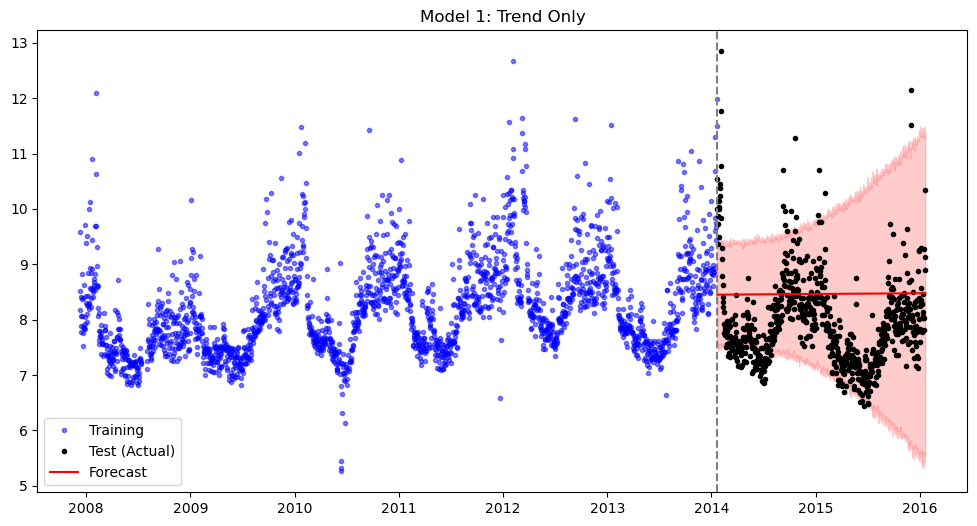

In [59]:
# Model 1: Basic - Trend only (no seasonality)
model1 = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model1.fit(train)

# Predict on test period
forecast1 = model1.predict(test[['ds']])

# Calculate metrics on test set
mae1 = mean_absolute_error(test['y'], forecast1['yhat'])
rmse1 = np.sqrt(mean_squared_error(test['y'], forecast1['yhat']))
print(f"Model 1 (Trend Only) - MAE: {mae1:.4f}, RMSE: {rmse1:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train['ds'], train['y'], 'b.', alpha=0.5, label='Training')
ax.plot(test['ds'], test['y'], 'k.', label='Test (Actual)')
ax.plot(forecast1['ds'], forecast1['yhat'], 'r-', label='Forecast')
ax.fill_between(forecast1['ds'], forecast1['yhat_lower'], forecast1['yhat_upper'], alpha=0.2, color='red')
ax.axvline(x=cutoff_date, color='gray', linestyle='--')
ax.set_title("Model 1: Trend Only")
ax.legend()
plt.show()

**Interpretation:** The basic trend-only model provides a baseline but misses the cyclical patterns in the data. It captures the general decline in page views over time but fails to predict the peaks and valleys. The forecast appears as a smooth line that doesn't follow the actual fluctuations in the test set.

### Model 2: Trend + Yearly Seasonality
Adding yearly seasonality to capture the annual patterns (e.g., NFL season spikes).

13:01:58 - cmdstanpy - INFO - Chain [1] start processing
13:01:58 - cmdstanpy - INFO - Chain [1] done processing
13:01:58 - cmdstanpy - INFO - Chain [1] done processing


Model 2 (Trend + Yearly) - MAE: 0.5421, RMSE: 0.6674


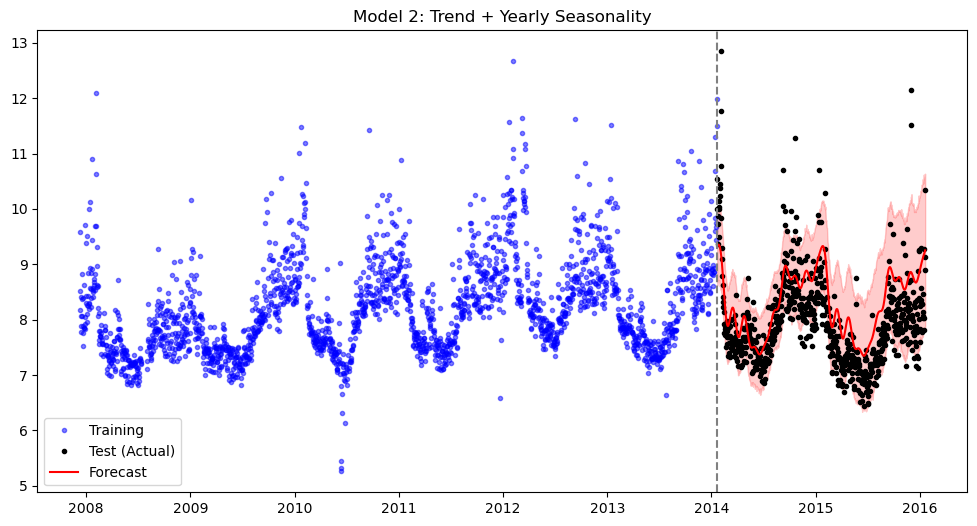

In [60]:
# Model 2: Trend + Yearly Seasonality
model2 = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model2.fit(train)

forecast2 = model2.predict(test[['ds']])

mae2 = mean_absolute_error(test['y'], forecast2['yhat'])
rmse2 = np.sqrt(mean_squared_error(test['y'], forecast2['yhat']))
print(f"Model 2 (Trend + Yearly) - MAE: {mae2:.4f}, RMSE: {rmse2:.4f}")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train['ds'], train['y'], 'b.', alpha=0.5, label='Training')
ax.plot(test['ds'], test['y'], 'k.', label='Test (Actual)')
ax.plot(forecast2['ds'], forecast2['yhat'], 'r-', label='Forecast')
ax.fill_between(forecast2['ds'], forecast2['yhat_lower'], forecast2['yhat_upper'], alpha=0.2, color='red')
ax.axvline(x=cutoff_date, color='gray', linestyle='--')
ax.set_title("Model 2: Trend + Yearly Seasonality")
ax.legend()
plt.show()

**Interpretation:** Adding yearly seasonality significantly improves the model. The forecast now captures the annual pattern of higher page views during the NFL season (September-February) and lower views during the off-season. This makes sense because Peyton Manning's relevance peaks when football is being played.

### Model 3: Trend + Yearly + Weekly Seasonality
Adding weekly seasonality to capture day-of-week patterns (e.g., games on Sundays).

13:01:59 - cmdstanpy - INFO - Chain [1] start processing
13:01:59 - cmdstanpy - INFO - Chain [1] done processing
13:01:59 - cmdstanpy - INFO - Chain [1] done processing


Model 3 (Trend + Yearly + Weekly) - MAE: 0.5634, RMSE: 0.6762


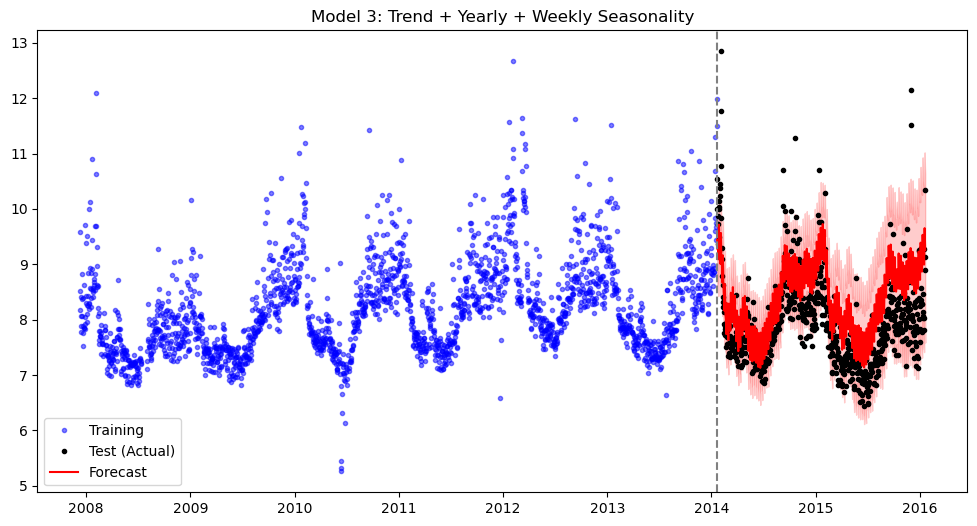

In [61]:
# Model 3: Trend + Yearly + Weekly Seasonality
model3 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model3.fit(train)

forecast3 = model3.predict(test[['ds']])

mae3 = mean_absolute_error(test['y'], forecast3['yhat'])
rmse3 = np.sqrt(mean_squared_error(test['y'], forecast3['yhat']))
print(f"Model 3 (Trend + Yearly + Weekly) - MAE: {mae3:.4f}, RMSE: {rmse3:.4f}")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train['ds'], train['y'], 'b.', alpha=0.5, label='Training')
ax.plot(test['ds'], test['y'], 'k.', label='Test (Actual)')
ax.plot(forecast3['ds'], forecast3['yhat'], 'r-', label='Forecast')
ax.fill_between(forecast3['ds'], forecast3['yhat_lower'], forecast3['yhat_upper'], alpha=0.2, color='red')
ax.axvline(x=cutoff_date, color='gray', linestyle='--')
ax.set_title("Model 3: Trend + Yearly + Weekly Seasonality")
ax.legend()
plt.show()

**Interpretation:** Weekly seasonality adds another layer of detail by capturing day-of-week patterns. NFL games are typically played on Sundays and Mondays, which likely causes spikes in Wikipedia searches on those days. However, the improvement may be modest since daily fluctuations average out over longer forecast horizons.

> ⚠️ **Note:** You may notice that adding weekly seasonality slightly *increases* the error compared to Model 2. This is the **weekly seasonality paradox** - adding more complexity doesn't always improve performance. Possible reasons:
> - The weekly pattern in the training data may not generalize well to the test period
> - Weekly effects are relatively small compared to yearly seasonality and get "lost in the noise"
> - The model may be slightly overfitting to training data patterns that don't persist

### Model 4: Full Model (Trend + Seasonality + Holidays)
The complete model with holidays (playoffs and Super Bowls) to capture special event effects.

13:01:59 - cmdstanpy - INFO - Chain [1] start processing
13:01:59 - cmdstanpy - INFO - Chain [1] done processing


Model 4 (Full Model with Holidays) - MAE: 0.5053, RMSE: 0.6094


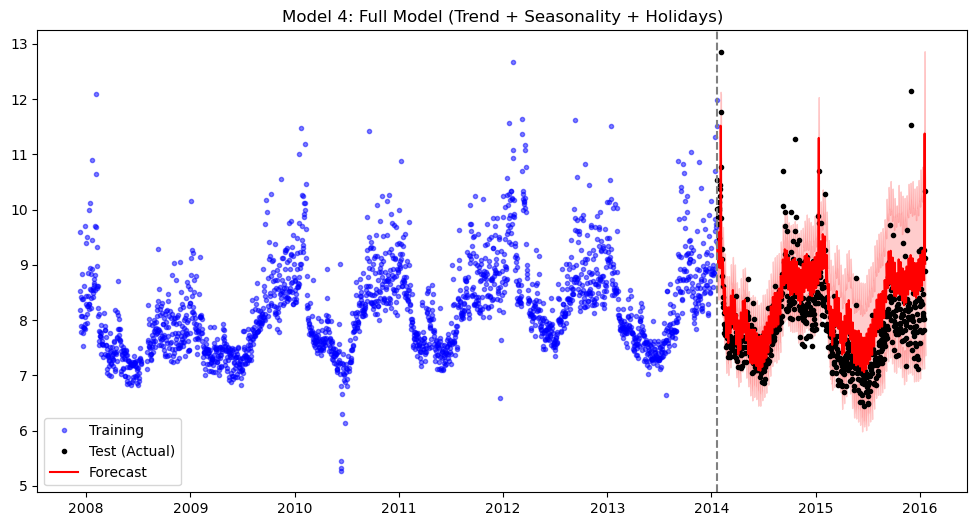

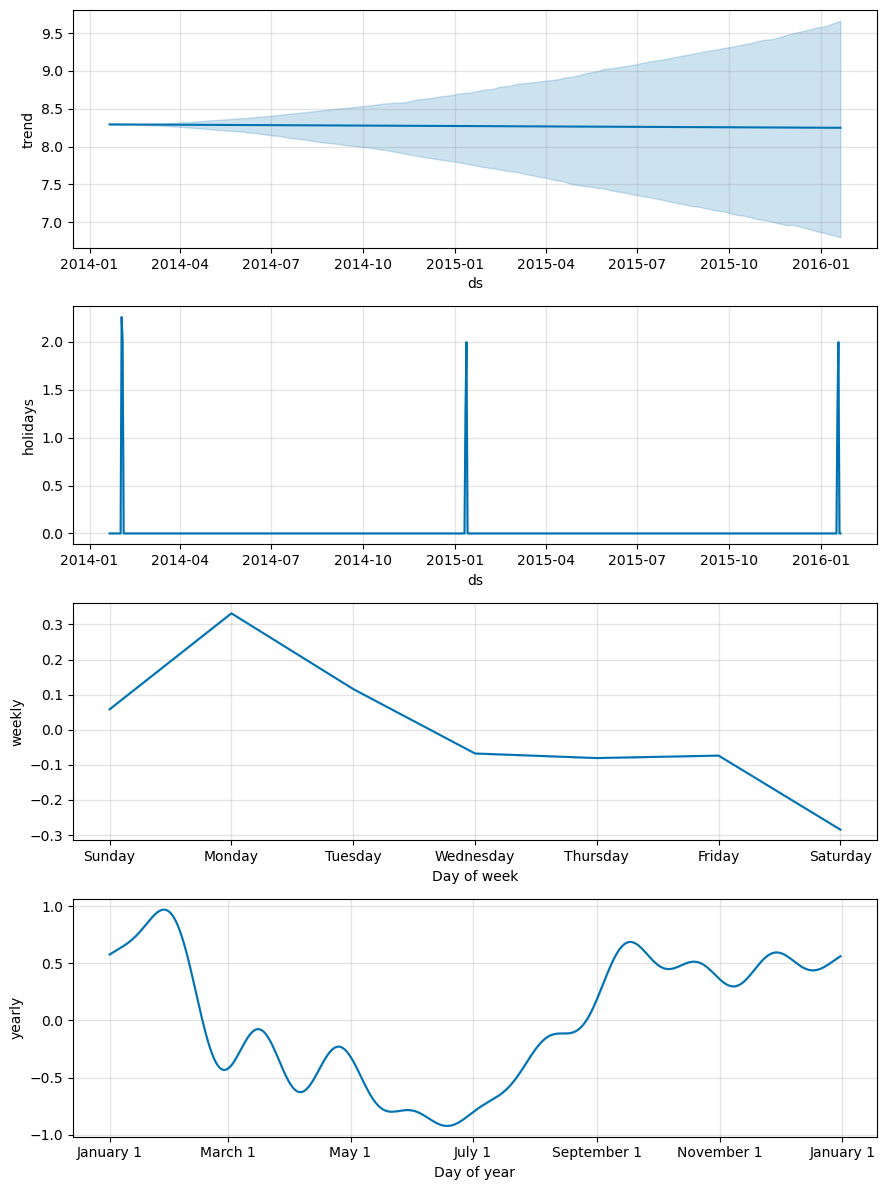

In [62]:
# Model 4: Full Model with Holidays
model4 = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model4.fit(train)

forecast4 = model4.predict(test[['ds']])

mae4 = mean_absolute_error(test['y'], forecast4['yhat'])
rmse4 = np.sqrt(mean_squared_error(test['y'], forecast4['yhat']))
print(f"Model 4 (Full Model with Holidays) - MAE: {mae4:.4f}, RMSE: {rmse4:.4f}")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train['ds'], train['y'], 'b.', alpha=0.5, label='Training')
ax.plot(test['ds'], test['y'], 'k.', label='Test (Actual)')
ax.plot(forecast4['ds'], forecast4['yhat'], 'r-', label='Forecast')
ax.fill_between(forecast4['ds'], forecast4['yhat_lower'], forecast4['yhat_upper'], alpha=0.2, color='red')
ax.axvline(x=cutoff_date, color='gray', linestyle='--')
ax.set_title("Model 4: Full Model (Trend + Seasonality + Holidays)")
ax.legend()
plt.show()

# Show the model components
fig2 = model4.plot_components(forecast4)
plt.show()

**Interpretation:** The full model with holidays should theoretically capture the extreme spikes during playoff games and Super Bowls. However, since these are rare events (only a few dates in the dataset), and the test set may not contain many of these events, the improvement might be limited. The holiday effect is most valuable when you need to explain historical anomalies or when you know similar events will occur in the future.

## 4-Model Comparison
Let's compare the performance of all models side by side to see how each component improves the forecast.

,Model,MAE,RMSE
0,1: Trend Only,0.811805,0.971237
1,2: + Yearly,0.542065,0.667405
2,3: + Weekly,0.563365,0.676206
3,4: + Holidays,0.505291,0.609432


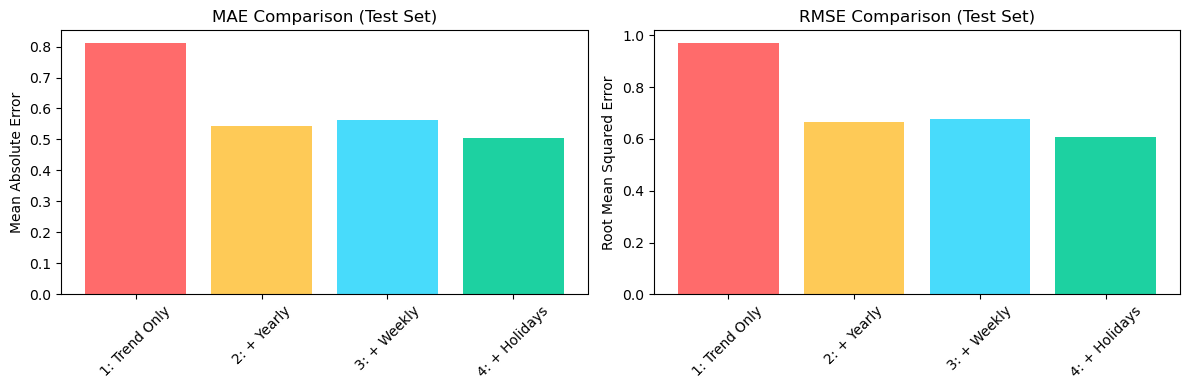

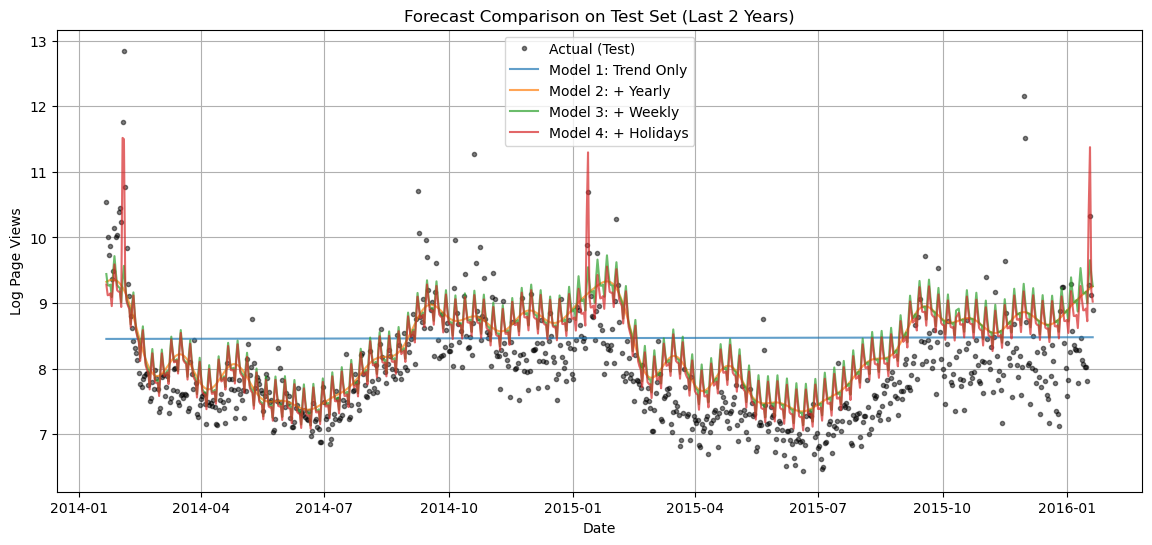

In [63]:
# Create a comparison dataframe
comparison = pd.DataFrame({
    'Model': ['1: Trend Only', '2: + Yearly', '3: + Weekly', '4: + Holidays'],
    'MAE': [mae1, mae2, mae3, mae4],
    'RMSE': [rmse1, rmse2, rmse3, rmse4]
})

display(comparison)

# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(comparison['Model'], comparison['MAE'], color=['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1'])
axes[0].set_title('MAE Comparison (Test Set)')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(comparison['Model'], comparison['RMSE'], color=['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1'])
axes[1].set_title('RMSE Comparison (Test Set)')
axes[1].set_ylabel('Root Mean Squared Error')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Overlay forecasts for visual comparison on test set
plt.figure(figsize=(14, 6))
plt.plot(test['ds'], test['y'], 'k.', alpha=0.5, label='Actual (Test)')
plt.plot(forecast1['ds'], forecast1['yhat'], label='Model 1: Trend Only', alpha=0.7)
plt.plot(forecast2['ds'], forecast2['yhat'], label='Model 2: + Yearly', alpha=0.7)
plt.plot(forecast3['ds'], forecast3['yhat'], label='Model 3: + Weekly', alpha=0.7)
plt.plot(forecast4['ds'], forecast4['yhat'], label='Model 4: + Holidays', alpha=0.7)
plt.title('Forecast Comparison on Test Set (Last 2 Years)')
plt.xlabel('Date')
plt.ylabel('Log Page Views')
plt.legend()
plt.grid(True)
plt.show()

## 5-Cross-Validation
While a single train/test split gives us one estimate of model performance, **cross-validation** provides a more robust evaluation by testing on multiple time periods. Prophet has built-in cross-validation that uses rolling forecast origins.

We will validate our best performing models using cross-validation and compare the results with our train/test split approach.

In [64]:
from prophet.diagnostics import cross_validation, performance_metrics

# Train models on the FULL dataset for cross-validation
# Model 3: Trend + Yearly + Weekly (without holidays)
model3_full = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model3_full.fit(df)

# Model 4: Full model with holidays
model4_full = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model4_full.fit(df)

print("Running cross-validation (this may take a few minutes)...")

# Cross-validation parameters:
# - initial: training period for the first fold (4 years)
# - period: spacing between cutoff dates (180 days)
# - horizon: forecast horizon to evaluate (365 days = 1 year)

cv_model3 = cross_validation(model3_full, initial='1460 days', period='180 days', horizon='365 days')
cv_model4 = cross_validation(model4_full, initial='1460 days', period='180 days', horizon='365 days')

print("Cross-validation complete!")

13:02:01 - cmdstanpy - INFO - Chain [1] start processing
13:02:01 - cmdstanpy - INFO - Chain [1] done processing
13:02:01 - cmdstanpy - INFO - Chain [1] done processing
13:02:01 - cmdstanpy - INFO - Chain [1] start processing
13:02:01 - cmdstanpy - INFO - Chain [1] start processing
13:02:02 - cmdstanpy - INFO - Chain [1] done processing
13:02:02 - cmdstanpy - INFO - Chain [1] done processing


Running cross-validation (this may take a few minutes)...


  0%|          | 0/7 [00:00<?, ?it/s]

13:02:02 - cmdstanpy - INFO - Chain [1] start processing
13:02:02 - cmdstanpy - INFO - Chain [1] done processing
13:02:02 - cmdstanpy - INFO - Chain [1] done processing
13:02:02 - cmdstanpy - INFO - Chain [1] start processing
13:02:02 - cmdstanpy - INFO - Chain [1] start processing
13:02:02 - cmdstanpy - INFO - Chain [1] done processing
13:02:02 - cmdstanpy - INFO - Chain [1] done processing
13:02:02 - cmdstanpy - INFO - Chain [1] start processing
13:02:02 - cmdstanpy - INFO - Chain [1] start processing
13:02:03 - cmdstanpy - INFO - Chain [1] done processing
13:02:03 - cmdstanpy - INFO - Chain [1] done processing
13:02:03 - cmdstanpy - INFO - Chain [1] start processing
13:02:03 - cmdstanpy - INFO - Chain [1] start processing
13:02:03 - cmdstanpy - INFO - Chain [1] done processing
13:02:03 - cmdstanpy - INFO - Chain [1] done processing
13:02:03 - cmdstanpy - INFO - Chain [1] start processing
13:02:03 - cmdstanpy - INFO - Chain [1] start processing
13:02:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

13:02:05 - cmdstanpy - INFO - Chain [1] start processing
13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing
13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1]

Cross-validation complete!


In [65]:
# Calculate performance metrics for cross-validation
metrics_cv3 = performance_metrics(cv_model3)
metrics_cv4 = performance_metrics(cv_model4)

print("=== Model 3 (Without Holidays) - Cross-Validation Metrics ===")
print(f"MAE: {metrics_cv3['mae'].mean():.4f}")
print(f"RMSE: {metrics_cv3['rmse'].mean():.4f}")
print(f"MAPE: {metrics_cv3['mape'].mean():.4f}")

print("\n=== Model 4 (With Holidays) - Cross-Validation Metrics ===")
print(f"MAE: {metrics_cv4['mae'].mean():.4f}")
print(f"RMSE: {metrics_cv4['rmse'].mean():.4f}")
print(f"MAPE: {metrics_cv4['mape'].mean():.4f}")

=== Model 3 (Without Holidays) - Cross-Validation Metrics ===
MAE: 0.5526
RMSE: 0.7134
MAPE: 0.0668

=== Model 4 (With Holidays) - Cross-Validation Metrics ===
MAE: 0.5451
RMSE: 0.6985
MAPE: 0.0661


### Comparison: Train/Test Split vs Cross-Validation
Let's compare the performance metrics from both evaluation approaches to see if our conclusions hold.

In [67]:
# Create comparison table
final_comparison = pd.DataFrame({
    'Model': ['Model 3 (No Holidays)', 'Model 3 (No Holidays)', 
              'Model 4 (With Holidays)', 'Model 4 (With Holidays)'],
    'Evaluation Method': ['Train/Test Split', 'Cross-Validation', 
                          'Train/Test Split', 'Cross-Validation'],
    'MAE': [mae3, metrics_cv3['mae'].mean(), 
            mae4, metrics_cv4['mae'].mean()],
    'RMSE': [rmse3, metrics_cv3['rmse'].mean(), 
             rmse4, metrics_cv4['rmse'].mean()]
})

display(final_comparison)


,Model,Evaluation Method,MAE,RMSE
0,Model 3 (No Holidays),Train/Test Split,0.563365,0.676206
1,Model 3 (No Holidays),Cross-Validation,0.552587,0.713407
2,Model 4 (With Holidays),Train/Test Split,0.505291,0.609432
3,Model 4 (With Holidays),Cross-Validation,0.545144,0.698544


### Key Insights from Results

#### Train/Test Split Results
| Model | MAE | RMSE |
|-------|-----|------|
| 1: Trend Only | 0.812 | 0.971 |
| 2: + Yearly | 0.542 | 0.667 |
| 3: + Weekly | 0.563 | 0.676 |
| 4: + Holidays | **0.505** | **0.609** |

**Observations:**
- **Yearly seasonality provides the biggest improvement** - MAE drops from 0.81 to 0.54 (~33% reduction)
- **Weekly seasonality slightly increases error** - MAE goes from 0.54 to 0.56 (counterintuitive!)
- **Holidays help on the test set** - Model 4 achieves the best test performance

#### Cross-Validation Results
| Model | MAE (CV) | RMSE (CV) |
|-------|----------|-----------|
| Model 3 (No Holidays) | 0.553 | 0.713 |
| Model 4 (With Holidays) | 0.545 | 0.699 |

#### Train/Test vs Cross-Validation Comparison
| Model | Train/Test MAE | CV MAE | Difference |
|-------|----------------|--------|------------|
| Model 3 | 0.563 | 0.553 | CV slightly better |
| Model 4 | 0.505 | 0.545 | Train/Test much better |

### Interpretation

1. **Model 4 appears "overly optimistic" on the train/test split**: The test set (2014-2016) contained several playoff games and Super Bowls where the holiday effect helped significantly. Cross-validation provides a more realistic estimate.

2. **The holiday effect is smaller than expected**: In cross-validation, holidays only improve MAE by ~0.008 (from 0.553 to 0.545) - a marginal **1.4% improvement**. This is because playoffs/Super Bowls are rare events.

3. **Cross-validation is more reliable**: The CV metrics are more consistent between models, suggesting the train/test split may have been "lucky" for Model 4.

4. **Recommended model**: Model 4 (with holidays) is still the best choice, but expect real-world performance closer to **MAE ~0.55** rather than 0.50.

## Conclusion

In this notebook, we demonstrated how to build a time series forecasting model using **Facebook Prophet** through an iterative approach:

1. **Start simple** - A trend-only model provides a baseline (MAE ~0.81)
2. **Add yearly seasonality** - Captures annual patterns like the NFL season (MAE drops to ~0.54)
3. **Add weekly seasonality** - Captures day-of-week effects, though benefits may be marginal
4. **Add holidays** - Accounts for special events like playoffs and Super Bowls (MAE ~0.50-0.55)

**Key lessons learned:**
- 📈 **Yearly seasonality provides the biggest improvement** for data with strong annual patterns
- ⚠️ **More complexity ≠ better performance** - weekly seasonality actually increased error slightly
- 🔄 **Cross-validation is essential** - a single train/test split can be misleading
- 🎯 **Domain knowledge matters** - understanding Peyton Manning's career and NFL schedule helped us define meaningful holidays

**Recommended approach for your own projects:**
1. Always start with EDA to understand your data's patterns
2. Build models iteratively, evaluating each component's contribution
3. Use cross-validation for reliable performance estimates
4. Incorporate domain-specific knowledge (holidays, events) when relevant